In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *
from equations import *
from PostProcessing import *

2024-01-04 09:33:08.274890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 09:33:08.591966: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 09:33:08.596958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /totten_1/chenggong/trunk-jpl/externalpackages/proj/install/lib:/totten_1/chenggong

In [3]:
epochADAM = 400000
epochLBFGS = 0
N_u=4000
N_H=4000
N_f=9000
N_C=None
seed=1234
log_frequency=10000
history_frequency=10
NLayers=6
NNeurons=20
noiseLevel=[]

In [4]:
hp = {}
# Data size on the solution u
hp["N_u"] = N_u
hp["N_s"] = N_u
hp["N_H"] = N_H
hp["N_C"] = N_C
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = N_f
# DeepNN topology (2-sized input [x,y], NLayers hidden layer of NNeurons-width, 1-sized output [u,v]
hp["layers"] = [2]+[NNeurons]*NLayers+[2]
# DeepNN topology (1-sized input [x,y], NLayers hidden layer of NNeurons-width, 2-sized output [h, H]
hp["h_layers"] = [2]+[NNeurons]*NLayers+[2]
# DeepNN topology (1-sized input [x,y], NLayers hidden layer of NNeurons-width, 1-sized output [C]
hp["C_layers"] = [2]+[NNeurons]*NLayers+[1]
# DeepNN topology (1-sized input [x], NLayers hidden layer of NNeurons-width, 4-sized input [u,v,C], 
#   1-sized output [taub]
hp["friction_layers"] = [4]+[NNeurons]*NLayers+[1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = epochADAM
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = epochLBFGS
hp["log_frequency"] = log_frequency
# Record the history
hp["save_history"] = True
hp["history_frequency"] = history_frequency

# path for loading data and saving models
repoPath = "./"
appDataPath = os.path.join(repoPath, "matlab_SSA", "DATA")
path = os.path.join(appDataPath, "Helheim_Weertman_iT080_PINN_fastflow_CF.mat")

modelFolder = 'Models_Kubeflow/2D/'

reloadModel = True
weights = [5, 3, 5, 10, 16]
loss_weights = [10**(-w) for w in weights]
logger = Logger(hp)

Hyperparameters:
{
  "N_u": 4000,
  "N_s": 4000,
  "N_H": 4000,
  "N_C": null,
  "N_f": 9000,
  "layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    2
  ],
  "h_layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    2
  ],
  "C_layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    1
  ],
  "friction_layers": [
    4,
    20,
    20,
    20,
    20,
    20,
    20,
    1
  ],
  "tf_epochs": 400000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 0,
  "log_frequency": 10000,
  "save_history": true,
  "history_frequency": 10
}

TensorFlow version: 2.11.0
Eager execution: True
GPU-accerelated: []


2024-01-04 09:33:13.159135: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /totten_1/chenggong/trunk-jpl/externalpackages/proj/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/netcdf/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/petsc/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/hdf5/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/gdal/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/triangle/install/lib:/totten_1/chenggong/Elmer/install/lib:
2024-01-04 09:33:13.159154: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-04 09:33:13.159170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (totten): /proc/driver/n

In [5]:
x, y, Exact_vx, Exact_vy, X_star, u_star, X_u_train, u_train, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb, mu = prep_2D_data_all(path, N_f=hp["N_f"], N_u=hp["N_u"], N_s=hp["N_s"], N_H=hp["N_H"], N_C=hp["N_C"],FlightTrack=False) #}}}

In [6]:
yts = 3600*24*365
X, Y = np.meshgrid(np.linspace(xlb[0],xub[0],400), np.linspace(xlb[1],xub[1], 400))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

# obs
u_obs = yts*griddata(X_star, u_star[:,0].flatten(), (X, Y), method='cubic')
v_obs = yts*griddata(X_star, u_star[:,1].flatten(), (X, Y), method='cubic')
s_obs = griddata(X_star, u_star[:,2].flatten(), (X, Y), method='cubic')
H_obs = griddata(X_star, u_star[:,3].flatten(), (X, Y), method='cubic')
C_obs = griddata(X_star, u_star[:,4].flatten(), (X, Y), method='cubic')
icemask = ((s_obs<0) + (np.isnan(s_obs)))
vel_obs = np.sqrt(u_obs**2+v_obs**2)

# interpolations
H_interp = griddata(X_u_train['H'], u_train['H'].flatten(), (X, Y), method='cubic')
C_interp = griddata(X_u_train['C'], u_train['C'].flatten(), (X, Y), method='cubic')

In [154]:
def plotall(u, H, s, C, icemask, X_u_train, H_nn_Hft=None, folder='./'):
    plotData = {}
    ########################### u
    plotData['uobs'] = vel_obs
    plotData['u'] = u
    plotData['u-uobs'] = plotData['u']-plotData['uobs']
    ########################### s
    plotData['sobs'] = s_obs
    plotData['s'] = s
    plotData['s-sobs'] = plotData['s']-plotData['sobs']
    ########################### C
    plotData['Cobs'] = C_obs
    plotData['C'] = np.abs(C)
    plotData['C-Cobs'] = plotData['C']-plotData['Cobs']
    ########################### H
    plotData['Hobs']= H_obs
    plotData['H'] = np.abs(H)
    plotData['H-Hobs'] = plotData['H']-plotData['Hobs']

    ########################### flight track
    if H_nn_Hft is not None:
        plotData['H_ft'] = H_nn_Hft*np.nan

    # colorbar range
    vranges={'u': [0,8e3], 'uobs': [0,8e3], 'u-uobs':[-1e3,1e3], 
             'H': [0,1.5e3], 'Hobs': [0,1.5e3], 'H-Hobs':[-0.4e3,0.4e3], 
             's': [0,2e3], 'sobs': [0,2e3], 's-sobs':[-0.25e3,0.25e3], 
             'C': [0,8e3], 'Cobs': [0,8e3], 'C-Cobs':[-2e3,2e3],
             'H_ft': [0, 1.5e3], 'H_ft_nn':[0,1.5e3],
             'C_ft_nn':[0,8e3],'C_ft_nn-Cobs':[-2e3,2e3],
             'H_ft_nn-Hobs':[-0.25e3,0.25e3]
    }


    # set ice mask
    for k in plotData.keys():
        plotData[k][icemask] = np.nan

    count = 0
    for name in plotData.keys():
        fig, ax = plt.subplots(1, 1 , figsize=(4,5))
        if count > 2 and count < 6: # surface
            cmap = 'terrain'
        elif count < 3: # vel
            cmap = cmap_Rignot()
        elif count > 8 and count< 15: # thickness
            cmap = 'viridis'
        elif count > 5 and count < 9: # friction
            cmap = 'jet'
        else:
            cmap = 'PiYG'

        if count % 3 == 2:
            cmap = 'PiYG'

        vr = vranges.setdefault(name, [None, None])

        if count < 2: # vel
            im = ax.imshow(plotData[name], interpolation='nearest', cmap=cmap,
                    extent=[X.min(), X.max(), Y.min(), Y.max()],
                    norm=mpl.colors.LogNorm(vmin=10, vmax=1.5e4),
                    origin='lower', aspect='auto')   
        else:
            im = ax.imshow(plotData[name], interpolation='nearest', cmap=cmap,
                    extent=[X.min(), X.max(), Y.min(), Y.max()],
                    vmin=vr[0], vmax=vr[1],
                    origin='lower', aspect='auto')

        if name == 'H_ft':
            im = ax.scatter(X_u_train['H'][:,0:1],X_u_train['H'][:,1:2],1,u_train['H'],
                      vmin=vr[0], vmax=vr[1], cmap='viridis')
            ax.scatter(X_bc[:,0:1],X_bc[:,1:2], 10, 'white')
            ax.set_xlim(X.min(), X.max())
            ax.set_ylim(Y.min(), Y.max())

    #     ax.set_title(name, fontsize=20)
        ax.axis('off')
        fig.colorbar(im, ax=ax, shrink=0.8, location='top')
        im.figure.axes[1].tick_params(axis="x", labelsize=18) 

        count += 1
        fig.savefig("Figures/Manuscript/"+folder+name+".pdf", format="pdf", bbox_inches='tight', dpi=600)

        print(name + ": " + "{0:.2f}".format(np.sqrt(np.nanmean(plotData[name]**2))) +
             ", " + str(np.nanpercentile(plotData[name], [1, 99])))

In [152]:
193.75/7000

0.027678571428571427

In [139]:
def computeError(pinn, X_star, u_star):
    u_pred, v_pred, s_pred, H_pred, C_pred = pinn.predict(X_star)
    err = {}
    err['u'] = (np.square(u_pred-u_star[:,0:1]))*yts*yts + (np.square(v_pred-u_star[:,1:2]))*yts*yts
    err['vel'] = np.square(np.sqrt(u_pred**2+v_pred**2)-np.sqrt(u_star[:,0:1]**2+u_star[:,1:2]**2))*yts*yts
    err['s'] = (np.square(s_pred-u_star[:,2:3]))
    err['H'] = (np.square(H_pred-u_star[:,3:4]))
    err['C'] = (np.square(C_pred-u_star[:,4:5]))
    for k in err.keys():
        print(k + ": " + "{0:.2f}".format(np.sqrt(np.nanmean(err[k]))))

# Load models

uobs: 2028.69, [2.79941390e-01 6.58385882e+03]
u: 2026.74, [1.05994708e+00 6.57937292e+03]
u-uobs: 70.64, [-127.27883328   96.26828406]
sobs: 987.66, [  87.57110372 1521.59609599]
s: 987.18, [  88.9078465  1521.20638664]
s-sobs: 12.99, [-32.9844909   31.76564719]
Cobs: 2662.32, [  30.63361288 5132.92622043]
C: 2659.53, [  30.56725142 5176.6695255 ]
C-Cobs: 114.55, [-323.7413548   291.14212463]
Hobs: 716.61, [   9.80024298 1490.0376287 ]
H: 700.07, [   2.11609253 1432.18106433]
H-Hobs: 69.47, [-253.1063658  129.6158078]


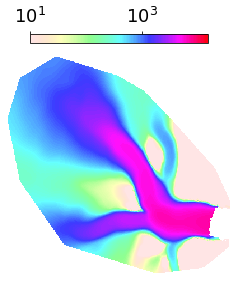

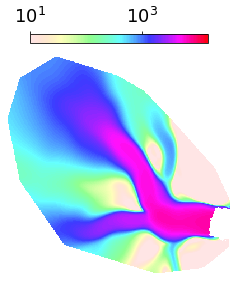

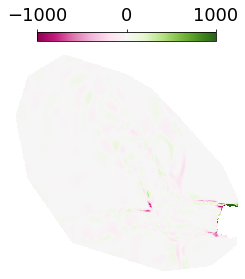

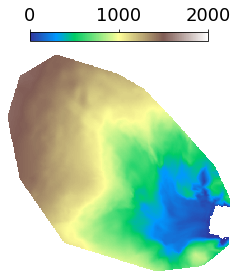

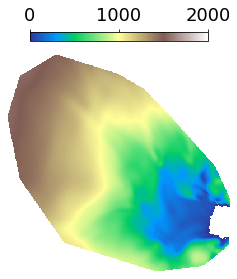

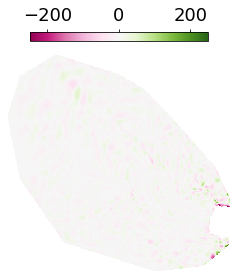

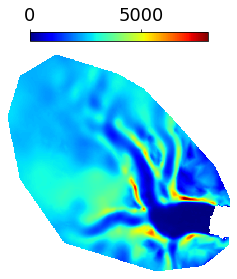

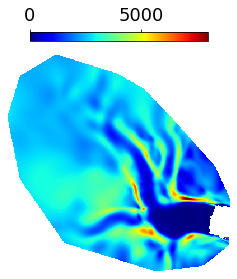

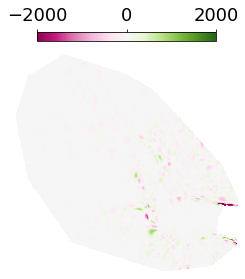

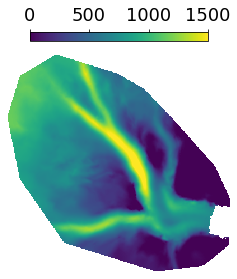

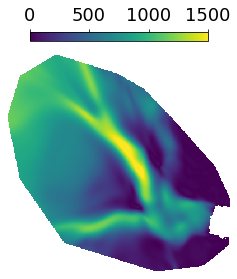

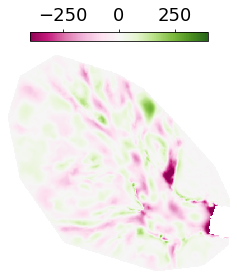

In [140]:
# invert H
modelname = 'SSA2D_knowningC_3NN_6x20_weights5_3_5_10_16_20231113_210249'
pinn_H = SSA_3NN(hp, logger, X_f,
        X_cf, n_cf,
        xub, xlb, uub, ulb,
        modelFolder + modelname, reloadModel=True,
        mu=mu,
        loss_weights=loss_weights)

# predicted solution
u_pred, v_pred, s_pred, H_pred, C_pred = pinn_H.predict(X_nn)
u_nn_H = np.reshape(u_pred, X.shape)*yts
v_nn_H = np.reshape(v_pred, X.shape)*yts
s_nn_H = np.reshape(s_pred, X.shape)
H_nn_H = np.reshape(H_pred, X.shape)
C_nn_H = np.reshape(C_pred, X.shape)
vel_nn_H = np.sqrt(u_nn_H**2+v_nn_H**2)
plotall(vel_nn_H, H_nn_H, s_nn_H, C_nn_H, icemask, X_u_train, H_nn_Hft=None, folder='solveH/')
# computeError(pinn_H, X_star, u_star)

uobs: 2028.69, [2.79941390e-01 6.58385882e+03]
u: 1998.27, [3.37554530e+00 6.38119139e+03]
u-uobs: 193.75, [-564.14361223  727.13190495]
sobs: 987.66, [  87.57110372 1521.59609599]
s: 987.20, [  74.10738334 1523.15437979]
s-sobs: 26.99, [-71.01454833  74.08423642]
Cobs: 2662.32, [  30.63361288 5132.92622043]
C: 2645.68, [  39.74511961 4872.27375304]
C-Cobs: 269.45, [-790.25986038  800.72164301]
Hobs: 716.61, [   9.80024298 1490.0376287 ]
H: 715.86, [  12.74042524 1484.50765564]
H-Hobs: 30.33, [-82.06396962  82.26954683]
u: 752.18
vel: 719.06
s: 84.54
H: 54.11
C: 321.61


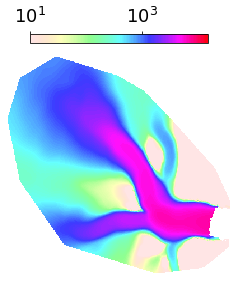

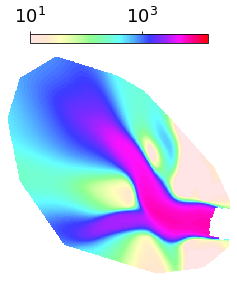

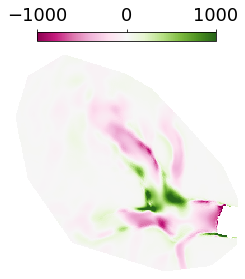

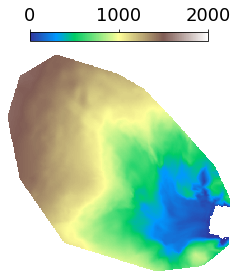

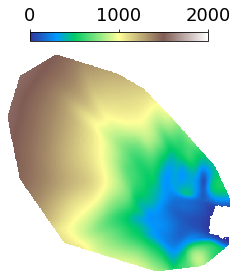

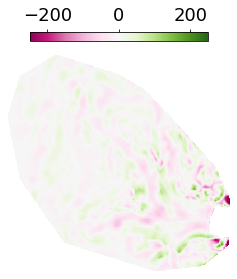

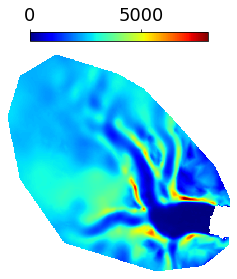

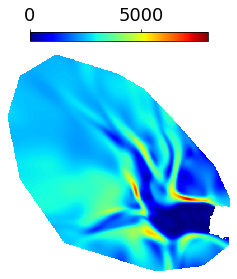

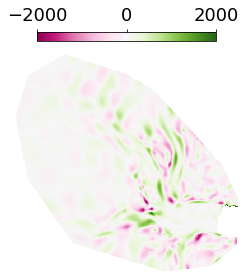

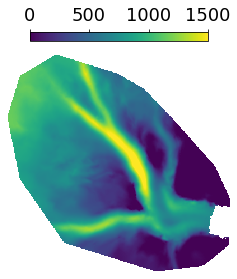

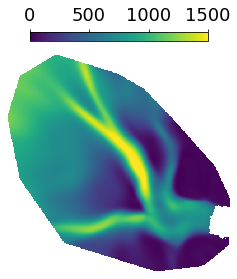

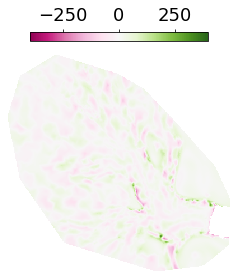

In [141]:
# solve u,v
modelname = 'SSA2D_solveU_3NN_6x20_weights5_3_5_7_17_20231230_022922'

pinn_u = SSA_3NN(hp, logger, X_f,
        X_cf, n_cf,
        xub, xlb, uub, ulb,
        modelFolder + modelname, reloadModel=True,
        mu=mu,
        loss_weights=loss_weights)

# predicted solution
u_pred, v_pred, s_pred, H_pred, C_pred = pinn_u.predict(X_nn)
u_nn_u = np.reshape(u_pred, X.shape)*yts
v_nn_u = np.reshape(v_pred, X.shape)*yts
vel_nn_u = np.sqrt(u_nn_u**2+v_nn_u**2)
s_nn_u = np.reshape(s_pred, X.shape)
H_nn_u = np.reshape(H_pred, X.shape)
C_nn_u = np.reshape(C_pred, X.shape)
vel_nn_u = np.sqrt(u_nn_u**2+v_nn_u**2)
plotall(vel_nn_u, H_nn_u, s_nn_u, C_nn_u, icemask, X_u_train, H_nn_Hft=None, folder='solveU/')
computeError(pinn_u, X_star, u_star)

uobs: 2028.69, [2.79941390e-01 6.58385882e+03]
u: 2027.10, [2.79915698e+00 6.57304927e+03]
u-uobs: 56.01, [-120.00736095  134.46953586]
sobs: 987.66, [  87.57110372 1521.59609599]
s: 987.74, [  93.5349134  1521.42025781]
s-sobs: 14.11, [-38.80327332  38.64367102]
Cobs: 2662.32, [  30.63361288 5132.92622043]
C: 2547.37, [  49.86579867 4909.42768827]
C-Cobs: 589.61, [-2211.18611806   849.7368241 ]
Hobs: 716.61, [   9.80024298 1490.0376287 ]
H: 715.96, [   3.16744712 1492.34282032]
H-Hobs: 18.96, [-48.63923642  45.16333945]
392.54
u: 784.01
vel: 783.12
s: 81.29
H: 80.91
C: 723.07


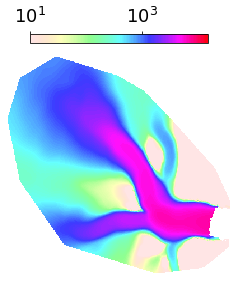

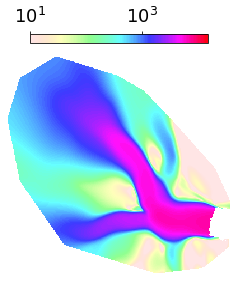

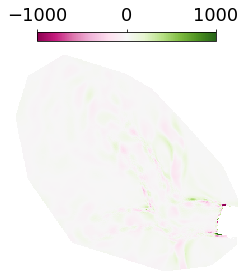

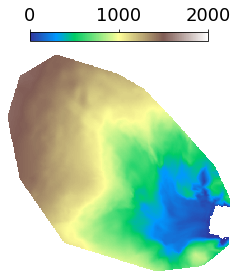

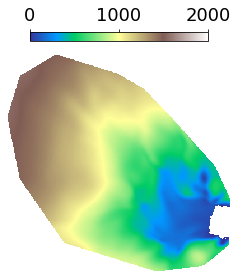

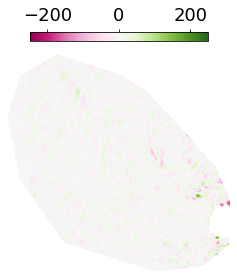

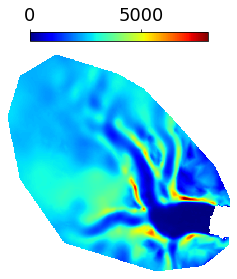

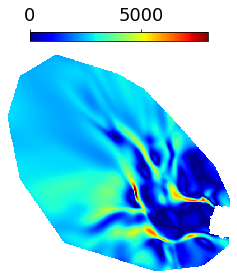

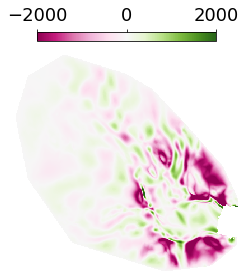

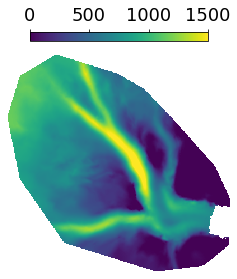

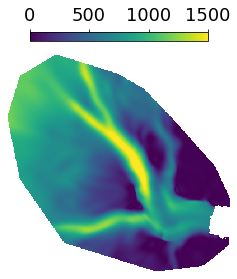

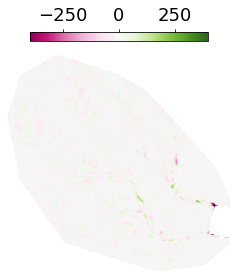

In [153]:
# invert C
modelname = 'SSA2D_3NN_test_3NN_6x20_weights5_3_5_10_16_20231109_220307'
pinn_C = SSA_3NN(hp, logger, X_f,
        X_cf, n_cf,
        xub, xlb, uub, ulb,
        modelFolder + modelname, reloadModel=True,
        mu=mu,
        loss_weights=loss_weights)

# predicted solution
u_pred, v_pred, s_pred, H_pred, C_pred = pinn_C.predict(X_nn)
u_nn_C = np.reshape(u_pred, X.shape)*yts
v_nn_C = np.reshape(v_pred, X.shape)*yts
s_nn_C = np.reshape(s_pred, X.shape)
H_nn_C = np.reshape(H_pred, X.shape)
C_nn_C = np.reshape(C_pred, X.shape)
vel_nn_C = np.sqrt(u_nn_C**2+v_nn_C**2)
plotall(vel_nn_C, H_nn_C, s_nn_C, C_nn_C, icemask, X_u_train, H_nn_Hft=None, folder='solveC/')
computeError(pinn_C, X_star, u_star)

In [174]:
plotData = {}
########################### u
plotData['uobs'] = vel_obs
########################### C
plotData['Cobs'] = C_obs
plotData['C'] = np.abs(C_nn_C)
plotData['C-Cobs'] = plotData['C']-plotData['Cobs']
plotData['Hobs'] = H_obs


Cnew = plotData['C-Cobs'][plotData['uobs']>10]
print("{0:.2f}".format(np.sqrt(np.nanmean(Cnew**2))))

392.54


Use 1347 flight track data for the ice thickness training data
uobs: 2028.69, [2.79941390e-01 6.58385882e+03]
u: 2017.78, [5.39335441e+00 6.45553985e+03]
u-uobs: 126.83, [-418.67001377  304.83071333]
sobs: 987.66, [  87.57110372 1521.59609599]
s: 987.39, [  93.69199077 1524.91478484]
s-sobs: 22.08, [-68.25603624  58.43919778]
Cobs: 2662.32, [  30.63361288 5132.92622043]
C: 2501.93, [  30.69452661 4410.08485821]
C-Cobs: 899.53, [-2934.8401828  2149.1399278]
Hobs: 716.61, [   9.80024298 1490.0376287 ]
H: 730.72, [5.85020428e-01 1.56157708e+03]
H-Hobs: 88.39, [-273.90462935  268.3160573 ]


/tmp/ipykernel_482411/2788066456.py:84: RuntimeWarning: Mean of empty slice
  print(name + ": " + "{0:.2f}".format(np.sqrt(np.nanmean(plotData[name]**2))) +
/totten_1/chenggong/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


H_ft: nan, [nan nan]
u: 805.21
vel: 801.77
s: 81.87
H: 108.71
C: 1034.38


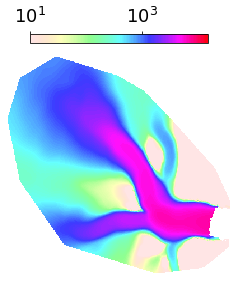

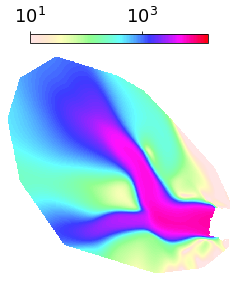

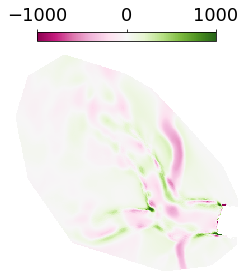

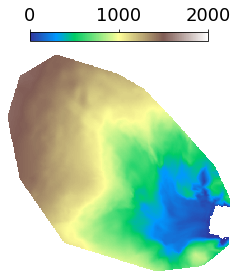

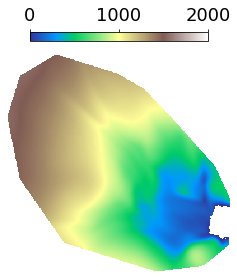

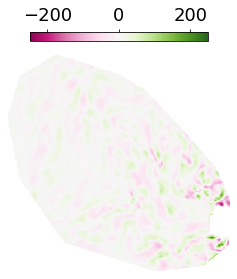

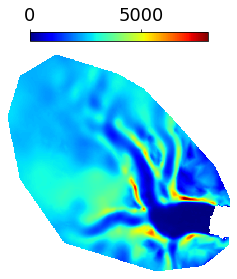

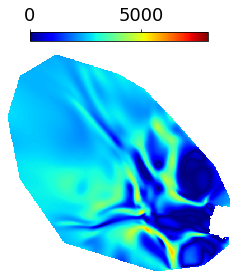

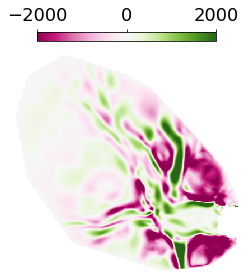

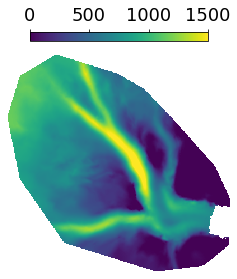

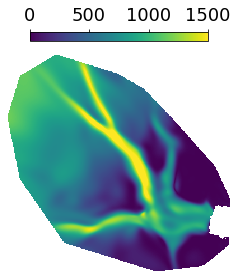

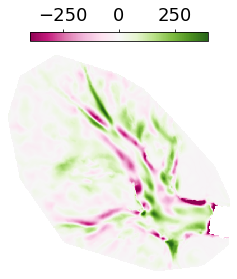

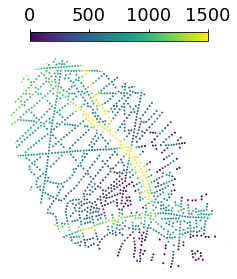

In [157]:
modelname = 'SSA2D_FlightTrackH_3NN_6x20_weights5_3_5_8_14_20231124_175437'

pinn_Hft = SSA_3NN(hp, logger, X_f,
        X_cf, n_cf,
        xub, xlb, uub, ulb,
        modelFolder + modelname, reloadModel=True,
        mu=mu,
        loss_weights=loss_weights)

x, y, Exact_vx, Exact_vy, X_star, u_star, X_u_train, u_train, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb, mu = prep_2D_data_all(path, N_f=hp["N_f"], N_u=hp["N_u"], N_s=hp["N_s"], N_H=hp["N_H"], N_C=hp["N_C"],FlightTrack=True) #}}}


# obs
H_flighttrack = griddata(X_star, u_star[:,3].flatten(), (X, Y), method='cubic')

# predicted solution
u_pred, v_pred, s_pred, H_pred, C_pred = pinn_Hft.predict(X_nn)
u_nn_Hft = np.reshape(u_pred, X.shape)*yts
v_nn_Hft = np.reshape(v_pred, X.shape)*yts
s_nn_Hft = np.reshape(s_pred, X.shape)
H_nn_Hft = np.reshape(H_pred, X.shape)
C_nn_Hft = np.reshape(C_pred, X.shape)
vel_nn_Hft = np.sqrt(u_nn_Hft**2+v_nn_Hft**2)
plotall(vel_nn_Hft, H_nn_Hft, s_nn_Hft, C_nn_Hft, icemask, X_u_train, H_nn_Hft=H_nn_Hft, folder='dualInv/')
computeError(pinn_Hft, X_star, u_star)

In [147]:
np.max(np.sqrt(u_star[:,0:1]**2+u_star[:,1:2]**2))*yts

7152.937001806728

In [148]:
193.75/7152.93

0.027086802191549474

In [179]:
70.64/2028

0.034832347140039445

In [180]:
114.55/2662.32

0.043026383004297

In [181]:
12.99/987.66

0.013152299374278599

In [150]:
18/710

0.02535211267605634

In [ ]:
    Invert for $H$ &  70.64 & 114.55 & 69.47 & 12.99 \\

% uobs: 2028.69, [1.81904613e-01 6.91894876e+03]
% Cobs: 2662.32, [  17.01847564 5996.13926269]
% Hobs: 716.61, [   8.40243232 1591.93819227]
% sobs: 987.66, [  47.67460807 1531.72445203]